In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The goal of this exercise session is to get familiar with inflow and stock-driven modelling. The goal of this exercise session is to get familiar with inflow and stock-driven modelling. You do not need to undertand all the details of the code. Make sure to understand the graphs, and answer the questions.

We will (1) use 2013–2023 EV sales data (inflow) to compute the evolution of the global EV stock (inflow-driven model), and (2) use a projection of future EV stock for 2024–2060 to calculate the required EV sales to maintain this stock (stock-driven model). We will then analyze and discuss the results.

EV sales data are sourced from [roadgenius.com](https://roadgenius.com/cars/ev/statistics/sales-by-country/). While the data may have limited reliability, it serves well for illustration purposes.

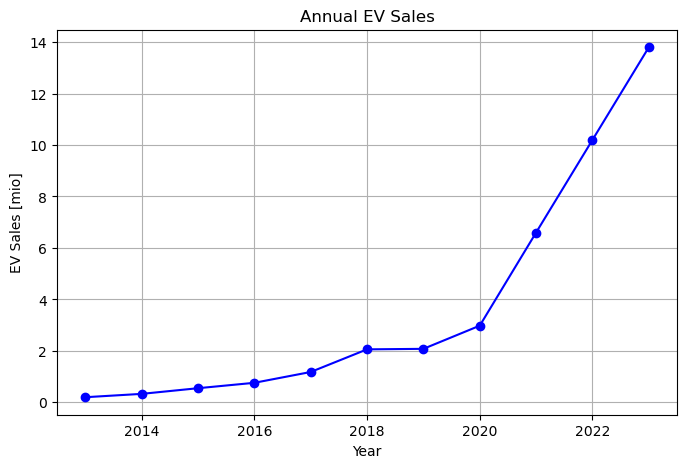

In [2]:
# Load EV sales data

I_df = pd.read_excel("EV_sales.xlsx", index_col=0).squeeze("columns") # EV sales data (inflow)
I = I_df.values.tolist()
years = I_df.index.tolist()

plt.figure(figsize=(8, 5))
plt.plot(years, I, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('EV Sales [mio]')
plt.title('Annual EV Sales')
plt.grid(True)
plt.show()


To compute the outflow of vehicles at each time step from the inflow, we need a **lifetime model**. This model is typically specified as a probability distribution function over vehicle lifetimes. Here, we use a discrete function that assigns the probability of a vehicle reaching its end-of-life in a given year \( t \).

In [3]:
# lifetime model

avg_lifetime = 15 # years

def lifetimes_pdf(t, avg_lifetime):
    """Probability density function of end-of-life time."""
    
    if (np.abs(t - avg_lifetime) == 0):
        return 0.3
    elif (np.abs(t - avg_lifetime) == 1):
        return 0.2
    elif (np.abs(t - avg_lifetime) == 2):
        return 0.1
    elif (np.abs(t - avg_lifetime) == 3):
        return 0.05
    else:
        return 0.0

We can evaluate this lifetime function for three age cohorts (2013, 2018, and 2023), and visualize the end-of-life probability for each of the cohorts.

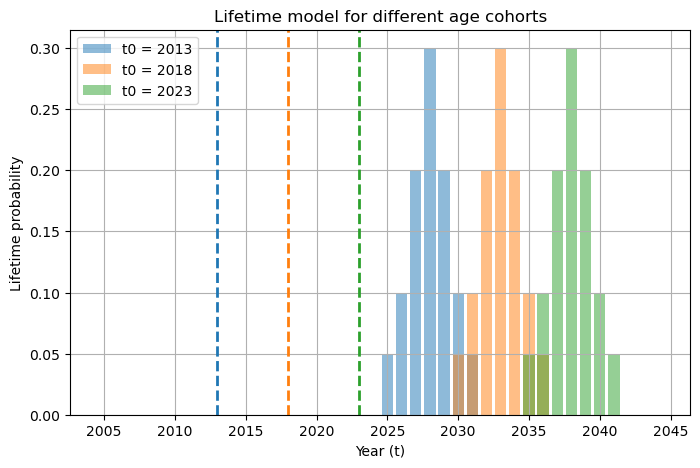

In [4]:
t_values = np.arange(2005, 2045)
age_cohort_examples = [2013, 2018, 2023] # age cohorts to visualize

plt.figure(figsize=(8, 5))
for age_cohort in age_cohort_examples:
    lifetime_probs = [lifetimes_pdf(t - age_cohort, avg_lifetime) for t in t_values]
    plt.bar(t_values, lifetime_probs, alpha=0.5, label=f't0 = {age_cohort}')

plt.xlabel('Year (t)')
plt.ylabel('Lifetime probability')
plt.title('Lifetime model for different age cohorts')
plt.legend()
plt.grid(True)

# Add vertical lines for 2013, 2018, and 2023 with matching colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for idx, age_cohort in enumerate(age_cohort_examples):
    plt.axvline(x=age_cohort, color=colors[idx % len(colors)], linestyle='--', linewidth=2, label=f'Cohort year: {age_cohort}')

plt.show()

Knowing the size of the inflow for each year, we can estimate when and how many vehicles from each age cohort reach their end-of-life. For example, for the age cohort 2013: $O_{2013}(t) = I(2013)*pdf_{2013}(t - 2013)$.

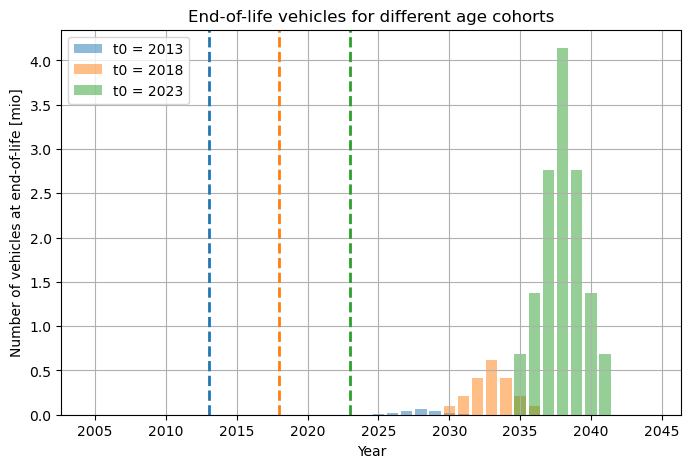

In [5]:
I_examples = [I[0], I[5], I[10]]  # 2013, 2018, 2023 sales
age_cohort_examples = [2013, 2018, 2023] # age cohorts to visualize

plt.figure(figsize=(8, 5))
for idx, age_cohort in enumerate(age_cohort_examples):
    # Calculate end-of-life vehicles for each year
    end_of_life_vehicles = [I_examples[idx] * lifetimes_pdf(t - age_cohort, avg_lifetime) for t in t_values]
    plt.bar(t_values, end_of_life_vehicles, alpha=0.5, label=f't0 = {age_cohort}')

plt.xlabel('Year')
plt.ylabel('Number of vehicles at end-of-life [mio]')
plt.title('End-of-life vehicles for different age cohorts')
plt.legend()
plt.grid(True)

# Add vertical lines for 2013, 2018, and 2023
for idx, age_cohort in enumerate(age_cohort_examples):
    plt.axvline(x=age_cohort, color=colors[idx % len(colors)], linestyle='--', linewidth=2, label=f'Cohort year: {age_cohort}')

plt.show()

With an empty initial stock, the inflow and the lifetime model, we have all the necessary elements to compute the 2013-2023 stock of electric vehicles using an inflow-driven model. Note that in the course slides, the time is continuous, so the outflow is computed by an integral. Here, the time is discrete (years), so the integral is replaced by a finite sum.


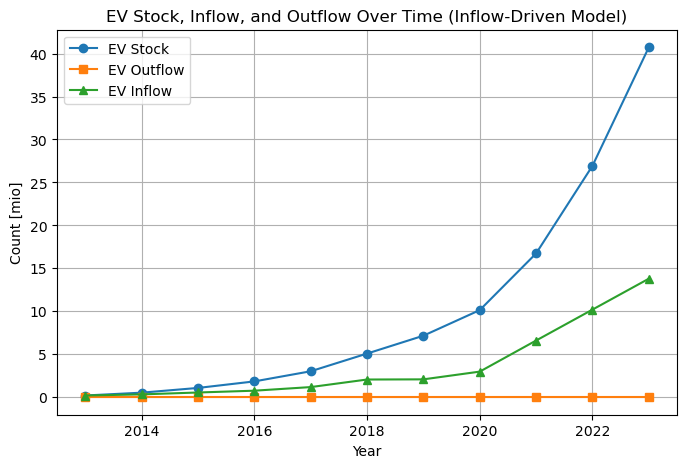

In [6]:
# inflow-driven model

S0 = 0 # initial EV stock in mio
S = [] # EV stock over time
O = [] # EV outflow over time

# Compute the total outflow for a given year using the lifetime model
def compute_total_outflow(I, years, outflow_year, avg_lifetime):
    """
    Calculates the total number of vehicles reaching end-of-life (outflow) in a specific year.

    Parameters:
        I (list): List of inflow (sales) for each year.
        years (list): List of years corresponding to inflow data.
        outflow_year (int): The year for which outflow is computed.
        avg_lifetime (int): Average vehicle lifetime in years.

    Returns:
        float: Total outflow (number of vehicles at end-of-life) for the given year.
    """
    assert len(I) == len(years), "Length of I and years must be the same"
    outflow_by_cohort = [
        I[cohort_year - years[0]] * lifetimes_pdf(outflow_year - cohort_year, avg_lifetime)
        for cohort_year in years
        if outflow_year >= cohort_year
    ]
    total_outflow = sum(outflow_by_cohort)
    return total_outflow

# Main loop of the inflow-driven model. We compute the outflow and stock for each year.
for outflow_year in years:
    # Calculate outflow for the current year using the lifetime model
    O_current_year = compute_total_outflow(I, years, outflow_year, avg_lifetime)
    
    # Calculate stock for the current year
    if outflow_year == years[0]:
        # For the first year, add initial stock and inflow, subtract outflow
        S_current_year = S0 + I[outflow_year - years[0]] - O_current_year
    else:
        # For subsequent years, add previous stock and inflow, subtract outflow
        S_current_year = S[-1] + I[outflow_year - years[0]] - O_current_year
    
    # Store results
    O.append(O_current_year)
    S.append(S_current_year)

plt.figure(figsize=(8, 5))
plt.plot(years, S, marker='o', label='EV Stock')
plt.plot(years, O, marker='s', label='EV Outflow')
plt.plot(years, I, marker='^', label='EV Inflow')
plt.xlabel('Year')
plt.ylabel('Count [mio]')
plt.title('EV Stock, Inflow, and Outflow Over Time (Inflow-Driven Model)')
plt.legend()
plt.grid(True)
plt.show()

    

**Question**: Why is the outflow zero on the above graph? What is the relationship between the stock and the inflow in this case?

**Results and Discussion:**  
The outflow is zero for the entire 2013-2023 period because the lifetime model assumes an average vehicle lifetime of 15 years. Vehicles sold between 2013 and 2023 have not yet reached their end-of-life, so none are removed from the stock during this interval. As a result, the stock simply accumulates the annual inflow (sales), and the stock in each year is the sum of all previous inflows minus any outflow (which is zero here). This means the stock curve closely follows the cumulative sales curve until vehicles begin to reach their end-of-life and outflow becomes nonzero.

Now, we would like to estimate future sales needed to reach a target stock for the period 2024-2060. For that, we need a stock projection. For simplicity, we use an S-curve fitting of the 2013-2023 data and extrapolate to 2060. Note that this scenario might be unrealistic, but we use it for illustration purpose.

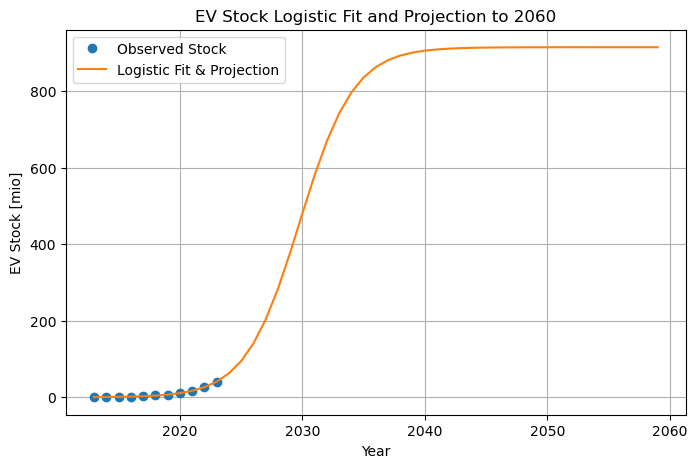

In [7]:
from scipy.optimize import curve_fit

years_extended = np.arange(2013, 2060)

# Fit the logistic curve to EV_stock data
x_data = np.array(years)
y_data = np.array(S)

# Logistic (sigmoid) function definition
def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

# Fit the logistic curve to EV_stock data
log_popt, _ = curve_fit(logistic, x_data, y_data, p0=[max(y_data), 0.3, 2018], maxfev=10000)

# Extrapolate to 2040
S_projection = logistic(years_extended, *log_popt)

plt.figure(figsize=(8, 5))
plt.plot(x_data, y_data, 'o', label='Observed Stock')
plt.plot(years_extended, S_projection, '-', label='Logistic Fit & Projection')
plt.xlabel('Year')
plt.ylabel('EV Stock [mio]')
plt.title('EV Stock Logistic Fit and Projection to 2060')
plt.legend()
plt.grid(True)
plt.show()


Now, we have all the required elements to compute a stock-driven model for the years 2024-2060. **Question**: Which are these elements?

**Answer**:
To compute the stock-driven model for 2024-2060, we need the following elements:

- The projected EV stock for each year 2024-2060 (from the logistic fit, `S_projection`)
- The historical inflow 2013-2023 (EV sales, `I`)
- The lifetime model to estimate vehicle outflow (`lifetimes_pdf` and `avg_lifetime`)

With these, we can iteratively calculate the required inflow (sales) for each year to achieve the target stock, accounting for vehicles reaching end-of-life and leaving the stock.

In [8]:
# stock-driven model

future_years = np.arange(2024, 2060)

for year in future_years:

    # compute outflow
    O_current_year = compute_total_outflow(I, years, year, avg_lifetime)

    # virtual stock: previous stock minus current outflow
    S_virtual = S_projection[year - years[0] - 1] - O_current_year

    # compute inflow needed to reach projected stock
    I_needed = S_projection[year - years[0]] - S_virtual

    # maintain the inflow and outflow series
    O.append(O_current_year)
    I.append(I_needed)
    years.append(year)


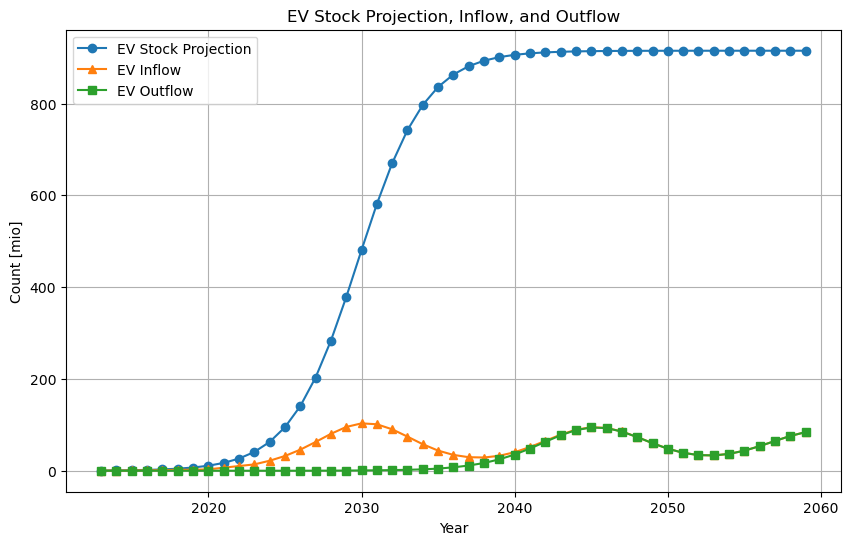

In [9]:
# plot results

plt.figure(figsize=(10, 6))
plt.plot(years_extended, S_projection, label='EV Stock Projection', marker='o')
plt.plot(years_extended, I, label='EV Inflow', marker='^')
plt.plot(years_extended, O, label='EV Outflow', marker='s')
plt.xlabel('Year')
plt.ylabel('Count [mio]')
plt.title('EV Stock Projection, Inflow, and Outflow')
plt.legend()
plt.grid(True)
plt.show()

**Results and Discussion:**

- **When does the outflow become significant?**  
    The outflow becomes significant around 2028–2030, when the first large cohorts of vehicles sold in the early 2010s begin to reach their end-of-life, as determined by the lifetime model (average lifetime ~15 years). Before this, outflow is nearly zero because vehicles are still within their expected lifespan. Due to the scale of the graph, the outflow only becomes visible around 2035-2040.

- **Where does the oscillation pattern in inflow and outflow come from?**  
    The oscillation pattern in outflow and inflow arises from the historical sales spikes. When a large cohort of vehicles reaches end-of-life, there is a corresponding spike in outflow. This, in turn, requires a spike in inflow (sales) to maintain or grow the stock, leading to visible oscillations in the curves.

- **Why does the inflow almost correspond to the outflow from 2040 to 2060?**  
    From 2040 onwards, the EV stock approaches saturation (the logistic curve flattens), so the stock grows very slowly. To maintain a stable stock, the number of new vehicles sold (inflow) must roughly match the number of vehicles reaching end-of-life (outflow). Thus, inflow and outflow become nearly equal, reflecting a steady-state replacement regime.


**Comment**: In this exercise, we used inflow-driven modelling to reconstruct historical EV stock and stock-driven modelling to estimate the required future inflow to achieve a projected stock. However, this approach is not universal. If historical stock data were available, stock-driven modelling could be applied to infer historical inflow. Likewise, if future inflow were known, inflow-driven modelling could be used to project future stock evolution.